<font size="+3"><strong>Development of a Mobile Application and Computer Vision Model for Automated Identification of Electronics Components</strong></font>

# Prepare Data

## Import

In [ ]:
# Importing necessary libraries
import warnings

import tensorflow as tf
# assert tf.__version__.startswith('2')

from google.colab import files # For downloading Files
from google.colab import drive # For Mounting Google drive
# import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib
# from tensorflow.keras import regularizers


from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
# from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

warnings.simplefilter(action="ignore", category=FutureWarning)

In [ ]:
# Mounting Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Moving to the necessary folder

%cd drive/MyDrive/Development of a Mobile Application and Computer Vision Model for Automated Identification of Electronics Components/New Dataset

[Errno 2] No such file or directory: 'drive/MyDrive/Development of a Mobile Application and Computer Vision Model for Automated Identification of Electronics Components/New Dataset'
/content/drive/MyDrive/Development of a Mobile Application and Computer Vision Model for Automated Identification of Electronics Components/New Dataset


In [ ]:
%ls -la

total 32
drwx------  2 root root 4096 May  9 18:45 Capacitor/
drwx------  2 root root 4096 Jun 11 21:45 Induction_Coil/
drwx------  2 root root 4096 Jun  9 11:08 path/
drwx------  2 root root 4096 May  9 18:45 Resistor/
drwx------  2 root root 4096 Jun  6 03:09 save/
drwx------ 12 root root 4096 Jun 13 18:09 Test_Datasets/
drwx------  2 root root 4096 May  9 18:45 Transistor/
drwx------ 12 root root 4096 May  9 18:45 upload/


## Split

In [ ]:
# Setting the base directory and defines constants for the data generator and model training

base_dir = 'upload'
base_dir = pathlib.Path(base_dir)
test_dir = 'Test_Datasets'
test_dir = pathlib.Path(test_dir)
VALIDATION_SPLIT = 0.2
SEED = 100
BATCH_SIZE = 32
IMAGE_SIZE = 128
# IMAGE_SIZE = 64
base_learning_rate = 0.0001

In [ ]:
# Creating the Image data generator with data augmentation

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
    )

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    # shuffle=True,
    seed=SEED,
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    # shuffle=True,
    seed=SEED,
    subset='validation')


test_generator = datagen.flow_from_directory(
    test_dir,  # Path to the directory containing your testing images
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False  # Set shuffle to False for testing set
)

Found 8008 images belonging to 10 classes.
Found 2001 images belonging to 10 classes.
Found 1007 images belonging to 10 classes.


In [ ]:
num_classes=10

for image_batch, label_batch in train_generator:
    break
image_batch.shape, label_batch.shape

((32, 128, 128, 3), (32, 10))

In [ ]:
# Generator is used to retrieve batch of images and labels for training

print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
    f.write(labels)

{'Battery': 0, 'Capacitor': 1, 'Cartridge_Fuse': 2, 'Circuit_Breaker': 3, 'Filament_Bulb': 4, 'Integrated_Circuit': 5, 'LED': 6, 'Pulse_Generator': 7, 'Resistor': 8, 'Transistor': 9}


In [ ]:
!cat labels.txt

Battery
Capacitor
Cartridge_Fuse
Circuit_Breaker
Filament_Bulb
Integrated_Circuit
LED
Pulse_Generator
Resistor
Transistor

## Explore

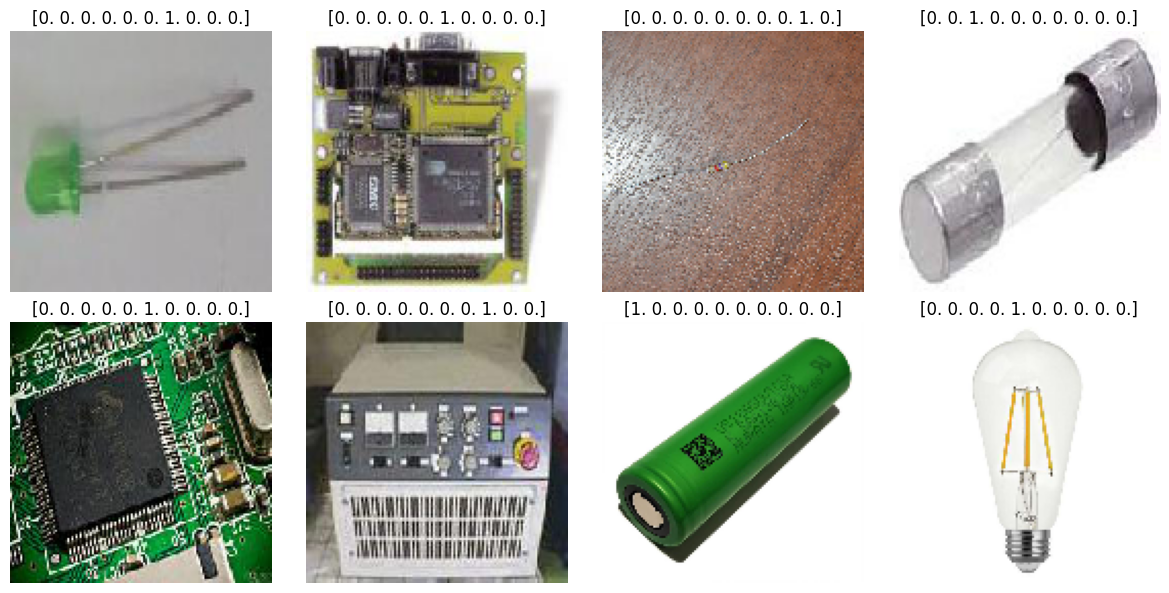

In [ ]:
# Display a few sample images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

for ax, (image, label) in zip(axes, train_generator):
    ax.imshow(image[0])
    ax.set_title(label[0])
    ax.axis('off')

plt.tight_layout()
plt.show()


Examine RGB values in an Image matrix


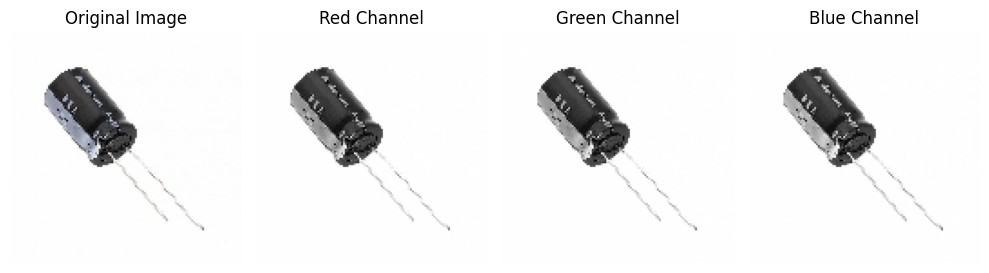

In [ ]:
# Accessing the first image in the batch
image = image_batch[0]

# Splitting the image into RGB channels
red_channel = image[:, :, 0]
green_channel = image[:, :, 1]
blue_channel = image[:, :, 2]

# Plotting the RGB channels
plt.figure(figsize=(10, 4))

plt.subplot(1, 4, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(red_channel, cmap='gray')
plt.title('Red Channel')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(green_channel, cmap='gray')
plt.title('Green Channel')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(blue_channel, cmap='gray')
plt.title('Blue Channel')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Accessing the first image in the batch
sample_image = train_generator[0][0][0]  # First image in the first batch

# Getting the size of the sample image
image_height, image_width, _ = sample_image.shape

# Printing the size
print(f"Sample image size: {image_width} x {image_height}")


Sample image size: 128 x 128


# Build Model

<p>A convolutional neural network (CNN). CNNs are a specific kind of artificial neural network that is very effective for image classification because they are able to take into account the spatial coherence of the image, i.e., that pixels close to each other are often related.</p>

<p>Building a CNN begins with specifying the model type. In our case, we'll use a <a href="https://keras.io/getting-started/sequential-model-guide/">Sequential</a> model, which is a linear stack of layers. We'll then add on it.</p>

A complete neural network architecture will have a number of other layers that are designed to play a specific role in the overall functioning of the network. Much deep learning research is about how to structure these layers into coherent systems.</p>
<p>layers:</p>
<ul>

- `tf.keras.Sequential`: This is the base model class in Keras that allows you to stack layers sequentially.

- `tf.keras.Input(shape=IMG_SHAPE)`: This creates an input layer with the specified shape (`IMG_SHAPE`). The input shape represents the shape of the input images that will be fed into the model.

- `tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)`: This layer randomly applies zoom augmentation to the input images. It randomly zooms in or out of the images by a factor of 0.2.

- `tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2)`: This layer randomly applies translation augmentation to the input images. It randomly shifts the images horizontally and vertically by a maximum of 0.2.

- `base_model`: This is a reference to a pre-trained model that will be used as a base for feature extraction. You need to replace `base_model` with an actual pre-trained model, such as ResNet50 or InceptionV3.

- `tf.keras.layers.GlobalAveragePooling2D()`: This layer performs global average pooling on the output of the base model. It reduces the spatial dimensions of the feature maps to a fixed size, regardless of the input image size.

- `tf.keras.layers.Dense(512, activation='relu')`: This adds a fully connected dense layer with 512 units and ReLU activation function. It serves as a hidden layer to learn complex representations from the pooled features.

- `tf.keras.layers.BatchNormalization()`: This layer normalizes the activations of the previous layer by adjusting and scaling them. It helps in stabilizing the learning process and improving generalization.

- `tf.keras.layers.Dropout(0.5)`: This layer applies dropout regularization to the inputs. It randomly sets a fraction of input units to 0 at each update during training, which helps in reducing overfitting.

- `tf.keras.layers.Dense(num_classes, activation='softmax')`: This adds the final dense layer with `num_classes` units (representing the number of classes in your classification problem) and softmax activation function. It outputs the predicted probabilities for each class.

Each layer in the model contributes to the overall architecture and helps in learning useful representations from the input images. The combination of data augmentation, base model, pooling, and fully connected layers helps in capturing and extracting meaningful features for classification tasks.
</ul>
<p>To take a look at how it all stacks up, we'll print the model summary. Notice that our model has a whopping <code>3,669,249</code> paramaters. These are the different weights that the model learns through training and what are used to generate predictions on a new image.</p>
<p><img src="https://assets.datacamp.com/production/project_555/img/mlp_conv.png" alt></p>

## Baseline Model / Models

In [ ]:
# MobileNetV2 base model

IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Experiementing with ResNet50
# base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=IMG_SHAPE)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

In [ ]:
base_model.trainable = False

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.5),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
])



In [ ]:
# First Model I tested

# model = tf.keras.Sequential([
#     tf.keras.Input(shape=IMG_SHAPE),
#     tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
#     base_model,
#     #tf.keras.layers.Conv2D(64, 3, activation='relu'),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])

In [ ]:
#Experimented with this Model

# model = tf.keras.Sequential([
#     tf.keras.Input(shape=IMG_SHAPE),
#     tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
#     tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
#     tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
#     base_model,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.BatchNormalization(),  # Added batch normalization
#     tf.keras.layers.Dropout(0.5),  # Increased dropout rate
#     tf.keras.layers.Dense(512, activation='relu'),  # Added a dense layer
#     tf.keras.layers.BatchNormalization(),  # Added batch normalization
#     tf.keras.layers.Dropout(0.5),  # Increased dropout rate
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])

In [ ]:
# # Experimented with this too

# model = tf.keras.Sequential([
#     tf.keras.Input(shape=IMG_SHAPE),
#     tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
#     base_model,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Conv2D(64, 3, activation='relu'),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])

In [ ]:
# Tried This too

# model = tf.keras.Sequential([
#     tf.keras.Input(shape=IMG_SHAPE),
#     tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
#     tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
#     base_model,
#     tf.keras.layers.Conv2D(32, 3, activation='relu'),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.BatchNormalization(),  # Added batch normalization
#     tf.keras.layers.Dropout(0.5),  # Increased dropout rate
#     tf.keras.layers.Dense(512, activation='relu'),  # Added a dense layer
#     tf.keras.layers.BatchNormalization(),  # Added batch normalization
#     tf.keras.layers.Dropout(0.5),  # Increased dropout rate
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])

In [ ]:
# Final Architecture.

model = tf.keras.Sequential([
    tf.keras.Input(shape=IMG_SHAPE),
    data_augmentation,
    base_model,
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# from tensorflow.keras import regularizers

# model = tf.keras.Sequential([
#     tf.keras.Input(shape=IMG_SHAPE),
#     tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
#     tf.keras.layers.experimental.preprocessing.RandomZoom(0.5),
#     tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
#     base_model,
#     tf.keras.layers.Conv2D(64, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])


## Iterate and Evaluate

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 64)          737344    
                                                                 
 global_average_pooling2d_2   (None, 64)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 512)               33280     
                                                                 
 batch_normalization_2 (Batc  (None, 512)             

In [ ]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 8


In [ ]:
loss0, accuracy0 = model.evaluate(val_generator)

 1/63 [..............................] - ETA: 3:41 - loss: 2.4424 - accuracy: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


63/63 [==============================] - 40s 594ms/step - loss: 2.4144 - accuracy: 0.0715


In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    # min_delta=0,
    patience=5,
    verbose=1,
    mode='max')

# checkpoint_filepath = 'path/best_model'

# # Create a ModelCheckpoint callback to save the best model
# mcc = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     monitor='val_accuracy',
#     save_best_only=True,
#     mode='max',
#     verbose=1
# )


More iterations

In [ ]:
initial_epochs = 100

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=initial_epochs,
                    validation_data=val_generator,
                    callbacks=[es],
                    validation_steps=len(val_generator))

Epoch 1/100
251/251 [==============================] - 228s 885ms/step - loss: 0.6601 - accuracy: 0.7891 - val_loss: 0.5163 - val_accuracy: 0.8381
Epoch 2/100
251/251 [==============================] - 215s 856ms/step - loss: 0.3614 - accuracy: 0.8840 - val_loss: 0.2991 - val_accuracy: 0.9230
Epoch 3/100
251/251 [==============================] - 221s 880ms/step - loss: 0.3129 - accuracy: 0.8974 - val_loss: 0.7128 - val_accuracy: 0.8266
Epoch 4/100
251/251 [==============================] - 225s 894ms/step - loss: 0.2682 - accuracy: 0.9120 - val_loss: 0.5549 - val_accuracy: 0.8436
Epoch 5/100
251/251 [==============================] - 245s 976ms/step - loss: 0.2452 - accuracy: 0.9195 - val_loss: 0.5870 - val_accuracy: 0.8571
Epoch 6/100
251/251 [==============================] - 226s 900ms/step - loss: 0.2302 - accuracy: 0.9246 - val_loss: 0.4202 - val_accuracy: 0.8601
Epoch 7/100
251/251 [==============================] - 215s 855ms/step - loss: 0.2300 - accuracy: 0.9240 - val_loss: 0

Accuracy and Loss


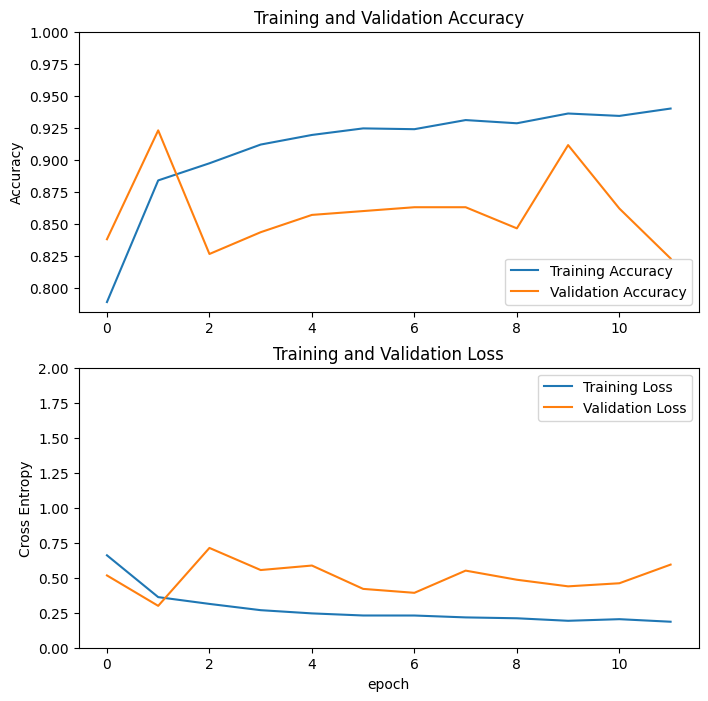

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']



loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Evaluate model on the testing set
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Loss: {test_loss:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')


32/32 [==============================] - 17s 522ms/step - loss: 1.0623 - accuracy: 0.7984
Test Loss: 1.06
Test Accuracy: 0.80


Precision, Recall, F1

In [ ]:
# Make predictions on the test data
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels

# Calculate Precision
precision = precision_score(y_true, y_pred_labels, average='macro')

# Calculate Recall
recall = recall_score(y_true, y_pred_labels, average='macro')

# Calculate F1 Score
f1 = f1_score(y_true, y_pred_labels, average='macro')

# Print the results
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


32/32 [==============================] - 19s 566ms/step
Precision: 0.82
Recall: 0.80
F1 Score: 0.78


Confusion Matrix

10/32 [========>.....................] - ETA: 10s

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


32/32 [==============================] - 17s 522ms/step


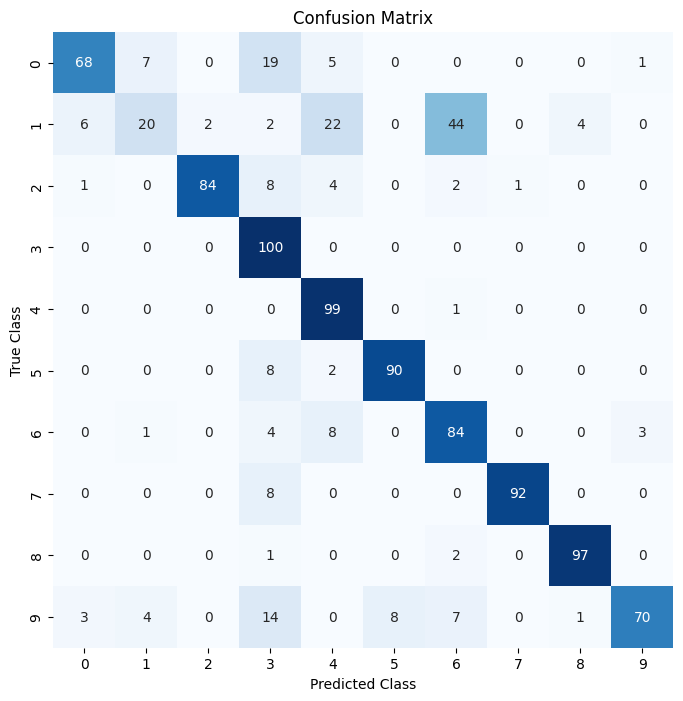

In [ ]:
# Step 1: Make predictions on the test data
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Step 2: Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()


ROC Curve + AUC

10/32 [========>.....................] - ETA: 10s

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


32/32 [==============================] - 17s 527ms/step


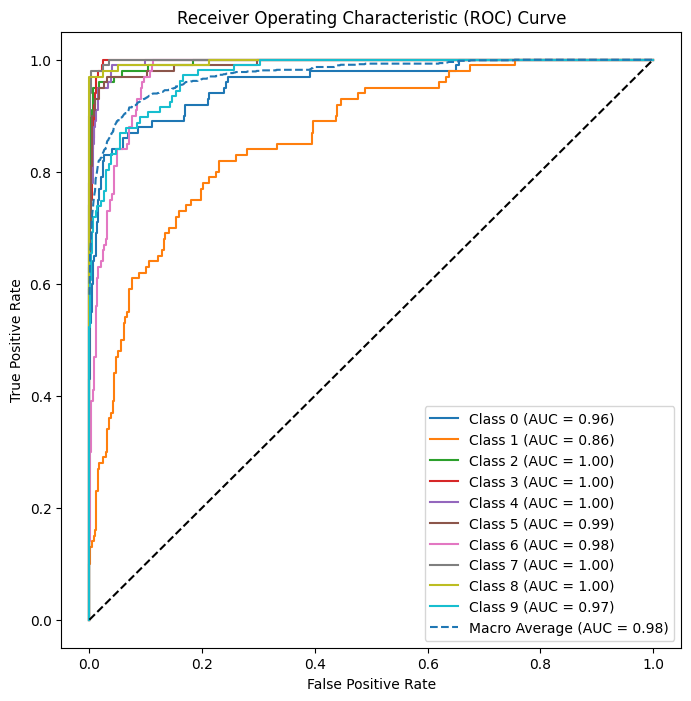

In [ ]:

# Step 1: Make predictions on the test data
y_pred_prob = model.predict(test_generator)
y_true = test_generator.classes
num_classes = test_generator.num_classes

# Step 2: Convert probabilities to binary matrix
y_pred_bin = np.argmax(y_pred_prob, axis=1)
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

# Step 3: Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 4: Compute macro-average ROC curve and AUC
fpr_macro = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
tpr_macro = np.zeros_like(fpr_macro)
for i in range(num_classes):
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= num_classes
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Step 5: Plot ROC curves for each class
plt.figure(figsize=(8, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot(fpr_macro, tpr_macro, label=f'Macro Average (AUC = {roc_auc_macro:.2f})', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.show()


In [ ]:
# Iterate

In [ ]:
epochs = 100

history1 = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=epochs,
                    validation_data=val_generator,
                    initial_epoch=history.epoch[-1],
                    callbacks=[es],
                    validation_steps=len(val_generator))

Epoch 6/100
 42/251 [====>.........................] - ETA: 2:33 - loss: 0.1900 - accuracy: 0.9293

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


251/251 [==============================] - 267s 1s/step - loss: 0.2166 - accuracy: 0.9308 - val_loss: 0.6282 - val_accuracy: 0.8321
Epoch 7/100
251/251 [==============================] - 210s 838ms/step - loss: 0.2155 - accuracy: 0.9296 - val_loss: 0.6468 - val_accuracy: 0.8406
Epoch 8/100
251/251 [==============================] - 215s 856ms/step - loss: 0.2061 - accuracy: 0.9299 - val_loss: 0.6290 - val_accuracy: 0.8451
Epoch 9/100
251/251 [==============================] - 253s 1s/step - loss: 0.1832 - accuracy: 0.9382 - val_loss: 0.5683 - val_accuracy: 0.8546
Epoch 10/100
251/251 [==============================] - 229s 912ms/step - loss: 0.1911 - accuracy: 0.9382 - val_loss: 0.8628 - val_accuracy: 0.8266
Epoch 11/100
251/251 [==============================] - 214s 852ms/step - loss: 0.1857 - accuracy: 0.9411 - val_loss: 0.7484 - val_accuracy: 0.8501
Epoch 12/100
251/251 [==============================] - 226s 900ms/step - loss: 0.1796 - accuracy: 0.9416 - val_loss: 0.5631 - val_acc

Accuracy and Loss # second iteration



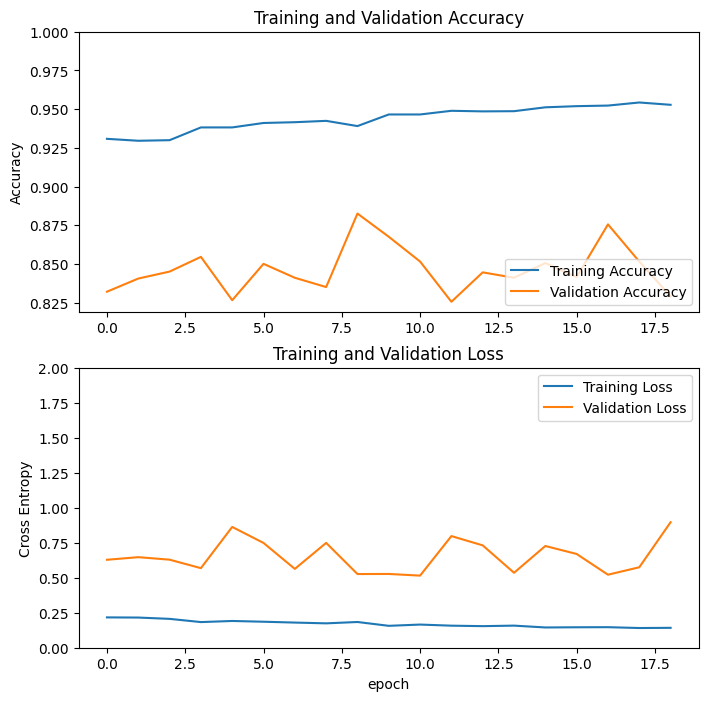

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']



loss = history1.history['loss']
val_loss = history1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Evaluate model on the testing set
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Loss: {test_loss:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')


10/32 [========>.....................] - ETA: 17s - loss: 2.9199 - accuracy: 0.5719

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


32/32 [==============================] - 23s 691ms/step - loss: 1.2475 - accuracy: 0.7865
Test Loss: 1.25
Test Accuracy: 0.79


Precision, Recall, F1 # second iteration

In [ ]:
# Make predictions on the test data
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels

# Calculate Precision
precision = precision_score(y_true, y_pred_labels, average='macro')

# Calculate Recall
recall = recall_score(y_true, y_pred_labels, average='macro')

# Calculate F1 Score
f1 = f1_score(y_true, y_pred_labels, average='macro')

# Print the results
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


32/32 [==============================] - 24s 719ms/step
Precision: 0.83
Recall: 0.79
F1 Score: 0.78


Confusion Matrix # second iteration

 9/32 [=======>......................] - ETA: 22s

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


32/32 [==============================] - 26s 810ms/step


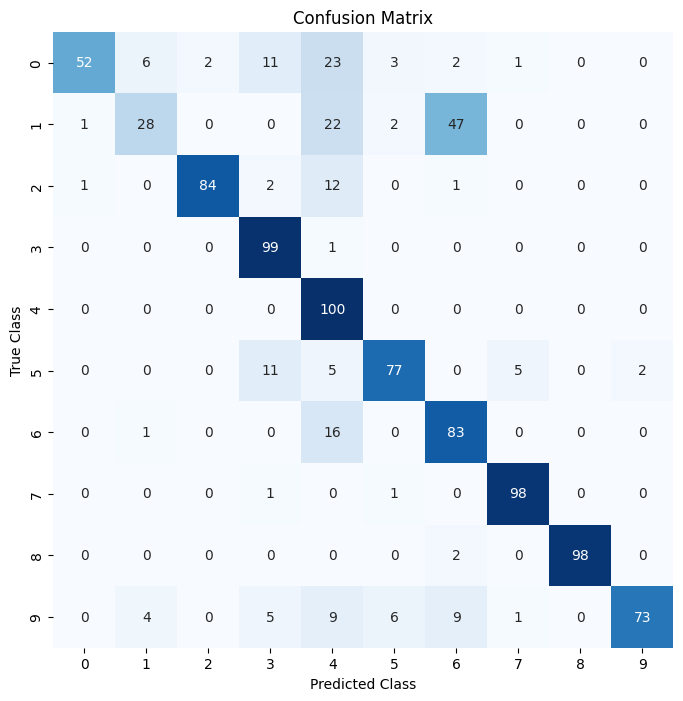

In [ ]:
# Step 1: Make predictions on the test data
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Step 2: Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()


ROC Curve + AUC # second iteration

 9/32 [=======>......................] - ETA: 11s

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


32/32 [==============================] - 17s 537ms/step


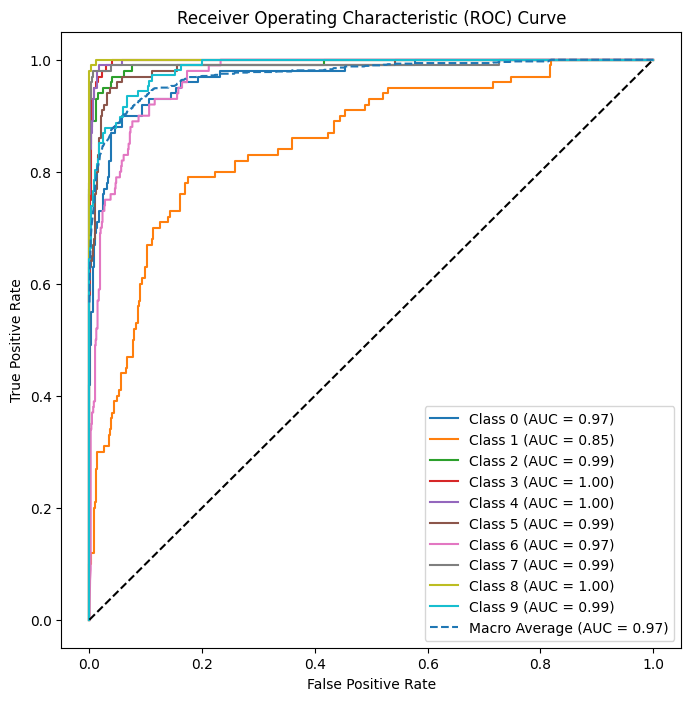

In [ ]:

# Step 1: Make predictions on the test data
y_pred_prob = model.predict(test_generator)
y_true = test_generator.classes
num_classes = test_generator.num_classes

# Step 2: Convert probabilities to binary matrix
y_pred_bin = np.argmax(y_pred_prob, axis=1)
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

# Step 3: Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 4: Compute macro-average ROC curve and AUC
fpr_macro = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
tpr_macro = np.zeros_like(fpr_macro)
for i in range(num_classes):
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= num_classes
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Step 5: Plot ROC curves for each class
plt.figure(figsize=(8, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot(fpr_macro, tpr_macro, label=f'Macro Average (AUC = {roc_auc_macro:.2f})', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.show()


### Fine Tuning / Iterate and Evaluate



In [ ]:
# # Set base_model.trainable = True to enable fine-tuning
# base_model.trainable = True

# # Compile the model with an appropriate optimizer and loss function
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
#               loss=tf.keras.losses.CategoricalCrossentropy(),
#               metrics=['accuracy'])

# # Print a summary of the model
# model.summary()


In [ ]:
# tf.keras.layers.Dropout(0.6),


In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [ ]:
# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [ ]:
print(base_learning_rate)

0.0001


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, None, None, None)  0         
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 64)          737344    
                                                                 
 global_average_pooling2d_2   (None, 64)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 512)               33280     
                                                                 
 batch_normalization_2 (Batc  (None, 512)             

In [ ]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 62


In [ ]:
fine_tune_epochs = 25
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_generator,
                         steps_per_epoch=len(train_generator),
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         callbacks=[es],
                         validation_data=val_generator,
                         validation_steps=len(val_generator))

Epoch 12/125
 42/251 [====>.........................] - ETA: 4:06 - loss: 1.0976 - accuracy: 0.7321

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


251/251 [==============================] - 363s 1s/step - loss: 0.5897 - accuracy: 0.8270 - val_loss: 4.4061 - val_accuracy: 0.3518
Epoch 13/125
251/251 [==============================] - 342s 1s/step - loss: 0.3507 - accuracy: 0.8951 - val_loss: 1.2791 - val_accuracy: 0.7726
Epoch 14/125
251/251 [==============================] - 331s 1s/step - loss: 0.3187 - accuracy: 0.8991 - val_loss: 3.2275 - val_accuracy: 0.5582
Epoch 15/125
251/251 [==============================] - 328s 1s/step - loss: 0.2518 - accuracy: 0.9180 - val_loss: 1.3362 - val_accuracy: 0.7046
Epoch 16/125
251/251 [==============================] - 334s 1s/step - loss: 0.2139 - accuracy: 0.9319 - val_loss: 0.6266 - val_accuracy: 0.8516
Epoch 17/125
251/251 [==============================] - 336s 1s/step - loss: 0.1707 - accuracy: 0.9447 - val_loss: 0.4732 - val_accuracy: 0.8826
Epoch 18/125
251/251 [==============================] - 331s 1s/step - loss: 0.1976 - accuracy: 0.9342 - val_loss: 0.7995 - val_accuracy: 0.846

Accuracy and Loss # fine tuned



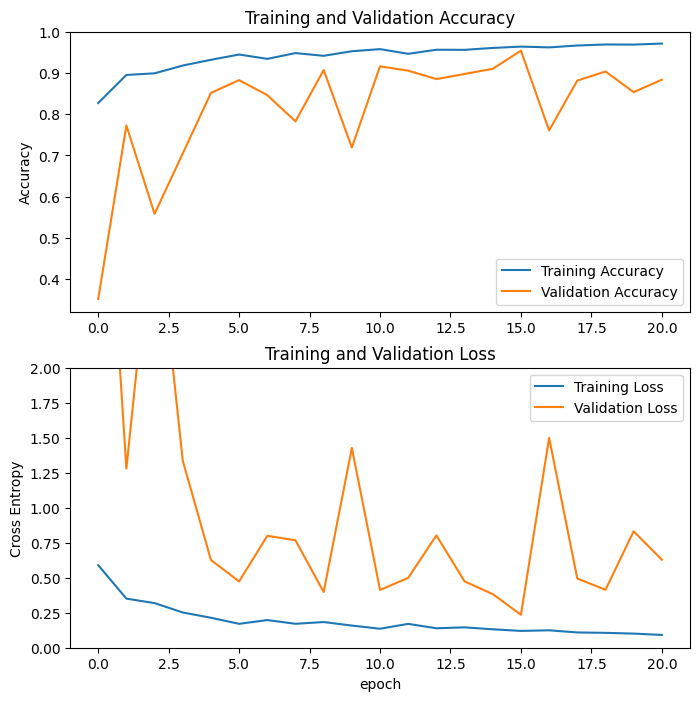

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']



loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Evaluate model on the testing set
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Loss: {test_loss:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')


10/32 [========>.....................] - ETA: 11s - loss: 3.5573 - accuracy: 0.5844

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


32/32 [==============================] - 18s 543ms/step - loss: 1.3729 - accuracy: 0.8133
Test Loss: 1.37
Test Accuracy: 0.81


Precision, Recall, F1 # fine tuned



In [ ]:
# Make predictions on the test data
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels

# Calculate Precision
precision = precision_score(y_true, y_pred_labels, average='macro')

# Calculate Recall
recall = recall_score(y_true, y_pred_labels, average='macro')

# Calculate F1 Score
f1 = f1_score(y_true, y_pred_labels, average='macro')

# Print the results
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


32/32 [==============================] - 19s 541ms/step
Precision: 0.87
Recall: 0.81
F1 Score: 0.81


Confusion Matrix # fine tuned

10/32 [========>.....................] - ETA: 15s

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


32/32 [==============================] - 20s 612ms/step


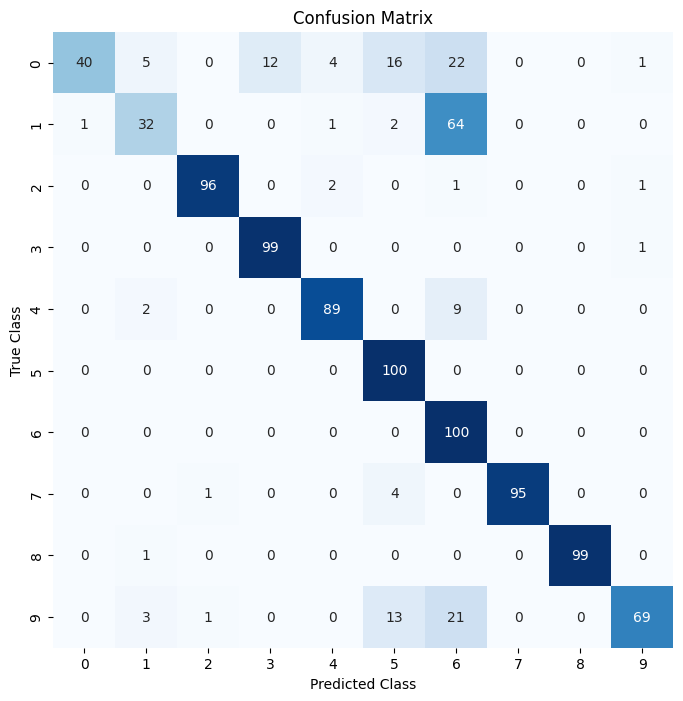

In [ ]:
# Step 1: Make predictions on the test data
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Step 2: Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()


ROC Curve + AUC # fine tuned

10/32 [========>.....................] - ETA: 11s

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


32/32 [==============================] - 17s 528ms/step


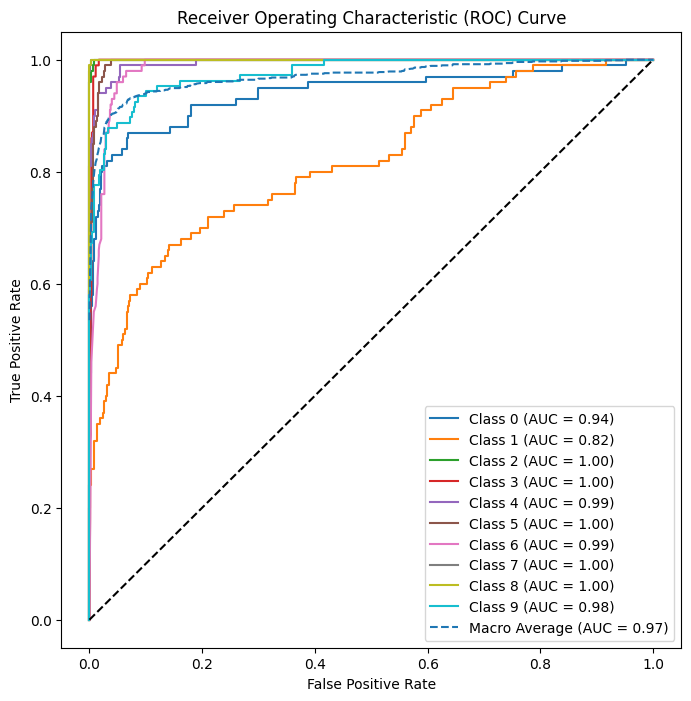

In [ ]:
# Step 1: Make predictions on the test data
y_pred_prob = model.predict(test_generator)
y_true = test_generator.classes
num_classes = test_generator.num_classes

# Step 2: Convert probabilities to binary matrix
y_pred_bin = np.argmax(y_pred_prob, axis=1)
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

# Step 3: Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 4: Compute macro-average ROC curve and AUC
fpr_macro = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
tpr_macro = np.zeros_like(fpr_macro)
for i in range(num_classes):
    tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
tpr_macro /= num_classes
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Step 5: Plot ROC curves for each class
plt.figure(figsize=(8, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot(fpr_macro, tpr_macro, label=f'Macro Average (AUC = {roc_auc_macro:.2f})', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.show()


# Saving Models

In [ ]:
%pwd

'/content/drive/MyDrive/Development of a Mobile Application and Computer Vision Model for Automated Identification of Electronics Components/New Dataset'

In [ ]:
# Naive Model

saved_model_dir = 'save/naive_model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('mobilenet_v2_naive_10model.tflite', 'wb') as f:
    f.write(tflite_model)


In [ ]:
files.download('mobilenet_v2_naive_10model.tflite')
files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Fine Tuned Model

saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('mobilenet_v2_fine_tuned10.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
files.download('mobilenet_v2_fine_tuned10.tflite')
files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>